# Wang-Landau sampling (WL)

The Wang-Landau approach recognises that to sample all energies with equal probabilty, we need the probability of sampling an individual microstate to be proportional to the inverse of the density of states at the energy of that microstate. In other words we seek a multicanonical ensemble in which:

$$ P\left(\{\vec{r}_j\}\right) \propto \frac{1}{g\left(U\left(\{\vec{r}_j\}\right)\right)}$$

More succinctly, if the energy of microstate $A$ is $U_A$ we should sample it in proportion to $1/g(U_A)$. Working through the detailed balance condition, the probability to accept a trial move from microstate $A$ to microstate $B$ should be:

$$P_\textrm{acc} = \min{\left[\frac{g(U_A)}{g(U_B)},1\right]} $$

Unfortunately, the density of states in energy isn't known _a priori_ and so like with the basic MUCA procedure we need to compute it iteratively. Wang and Landau proposed the following:

1. Set $f=\mathrm{e}$.
2. Start with an estimate of $g(U) = 1$ for all energies.
3. Perform an MC simulation with the above acceptance criterion. Upon visiting any energy bin, update the estimate of the density of states $g(U)$ for that bin by multiplying by $f$. Increment a count/histogram of visits to each bin by 1.
4. Once a "flat" histogram (all bins > 80% of the mean) is acheived, updated $f\rightarrow \sqrt{f}$, reset the histogram and repeat from step 3.

This continues until $f$ is negligibly different from 1, at which point the procedure is stopped. Quantities which depend only on the energy can be computed directly from $g(U)$. Other quantities must be sampled along with the energy at which the sample was generated in a long simulation with static $g(U)$ and can then reweighted to give averages at any temperature like with the MUCA procedure in the last notebook.

The interative refinement of $g(U)$ has subsequently been refined by various authors, e.g. most agree that $f$ should initially be $1.005$ or smaller, and that the flatness criteria on the histogram at each iteration should be tighter. Most groups have their own tweaked procedure.

This is illustrated below.

## Demonstration on our simple bead and spring "polymer" model

See `Basic_MMC.ipynb` and `polymer.py` for details of the model.

One important detail is that we work with the logarithm of $g(U)$ and not the function itself to avoid overflow errors. The density of states can be extremely large. Note also that we only care about the relative magnitude of $g(U)$ so will regularly adjust it downward 
such that the density of states in the zeroth (lowest energy) bin is 1. 

### Import packages and create some binning functions functions

In [1]:
# Import all the things
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [3]:
def bin_index(x, bin_edges):
    """Given a list of bin_edges returned from numpy.histogram, and a sampled value x, 
       return the index of the bin in which x lies. Note that np.digitize is annoying
       and I don't like it.

    Parameters:
    x (float) : sample to assign to a bin
    bin_edges : bin edges as returned from numpy.histogram 

    Returns:
    i         : index of bin in which sample lies

    """
    
    bin_range = bin_edges[-1] - bin_edges[0]
    bin_pos = x - bin_edges[0]

    return int( (bin_pos/bin_range)*(len(bin_edges)-1.0) )

### Function to implement WL sampling on the polymer

This requires only minimal changes from that in `MUCA.ipynb`. There is now no bias energy, but we accept reject based only the current estimate of $g(U)$.

In [10]:
def run_wl_sweeps(chain, bin_edges, wl_hist, wl_logdos, wl_f, Nsweeps=100, max_disp=0.15, sample_int=100):
    """Performs WL MC on the provided chains for a number of "sweeps" where one sweep is on average
       an attempt to move each mobile particle once. 

    Parameters:
    chain       : polymer object to sample configurations of
    bin_edges   : energy bin edges as returned from numpy.histogram 
    wl_hist     : current histogram of vists to each energy bin
    wl_logdos   : current estimate of g(U) for each energy bin
    Nsweeps     : number of sweeps to perform
    max_disp    : maximum trial displacement (distance)
    temperature : temperature of heat bath the polyer is coupled to
    sample_int  : interval at which to record samples of energy and end-to-end distance 

    Returns:
    chain       : final state of the polymer
    samples     : list of tuples ( energy, end-to-end distance) of recorded samples
    ratio       : fraction of moves that were accepted

   """

    # Initialise sampling for the current set of sweeps
    samples = []
    acount  = 0

    # Establish total energy before any moves
    old_energy = chain.energy()

    # Each sweep is one trial per bead on average
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1, chain.Nbeads) # first bead never moves

        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        # Make trial move and compute energy change - note we only compute the terms 
        # in the energy which depend on ibead. See polymer.py
        old_local_energy = chain.local_energy(ibead)
        chain.rpos[ibead] = chain.rpos[ibead] + disp
        new_local_energy = chain.local_energy(ibead)

        # Find bias energy V for old_energy U before move
        ibin = bin_index(old_energy, bin_edges)

        # Find bias energy V for new_energy U after move
        new_energy = old_energy + ( new_local_energy - old_local_energy )
        jbin = bin_index(new_energy, bin_edges)
        

        # Only compute g(U) change if within limits where defined
        if jbin in range (0, len(wl_hist)):

            # (Changed for WL) accept based on change in density of states
            if np.random.sample() < m.exp(wl_logdos[ibin]-wl_logdos[jbin]):
                # accepted
                acount = acount + 1
                old_energy = new_energy # update old_energy for next move
                    
            else:
                # reject and reset
                chain.rpos[ibead] = chain.rpos[ibead] - disp
                jbin = ibin # haven't changed bin

            # (New for WL) update histogram and density of states
            wl_hist[jbin] += 1
            wl_logdos[jbin] += wl_f


        else:
            # reject and reset
            chain.rpos[ibead] = chain.rpos[ibead] - disp
            
        
        # Sample energy and end-to-end distance every sample_int sweeps
        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

        ratio = acount/(Nsweeps*(chain.Nbeads-1)) 

    return chain, samples, wl_hist, wl_logdos, ratio   

### Setup a simulation which uses the above to iteratively refine g(U)

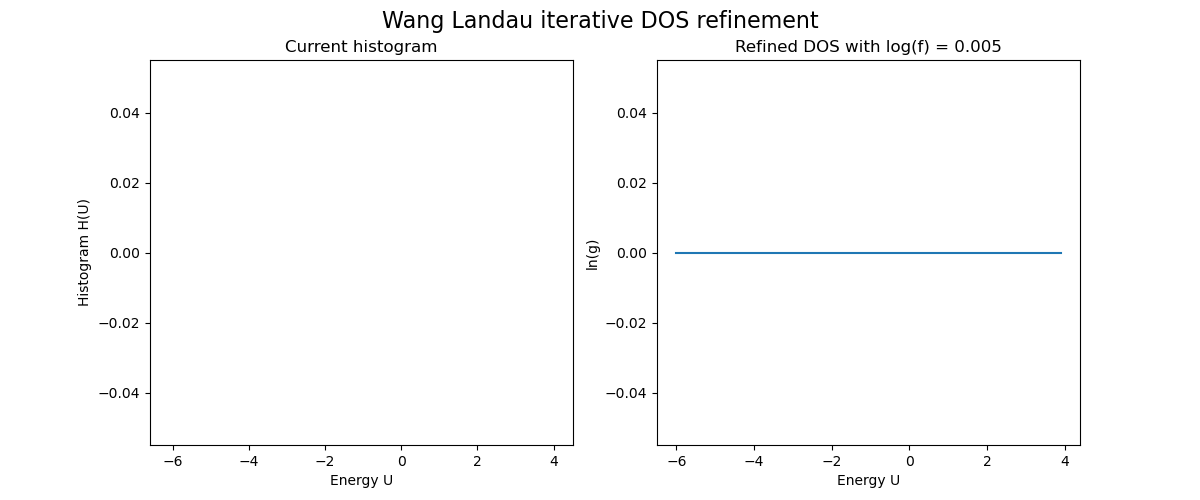

In [20]:
# Initialise wl_simulation
Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Initialise histogram and log of DOS
wl_hist   = np.zeros(len(bin_edges)-1)
wl_logdos = np.zeros(len(bin_edges)-1)

# Initialise f, noting it's actually ln(f) that we store and update
wl_f = 0.005

# Setup some plots
%matplotlib widget

def label_wl_figure(fig, ax1, ax2, wl_f):
    """ Sets up figures and axis for WL demonstration """

    ax1.set_xlabel('Energy U')
    ax2.set_xlabel('Energy U')
    ax1.set_ylabel('Histogram H(U)')
    ax2.set_ylabel('ln(g)')
    fig.suptitle('Wang Landau iterative DOS refinement', fontsize=16)
    ax1.set_title('Current histogram')
    ax2.set_title('Refined DOS with log(f) = '+ str(wl_f))

    return

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
label_wl_figure(fig, ax1, ax2, wl_f)
ax1.bar(bin_edges[:-1], wl_hist, width=bin_width, align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
plt.show()

## Run frames of 100 WL sweeps each until we reach a sufficiently small $f$

In [21]:
from ipywidgets import IntProgress
from IPython.display import display

# Initialise list of samples for current cycle
samples = []

# It helps to disregard the histogram built up in the period before all bins are visited a few times
first_reset = False

# When using WL in production we might go as low as machine precision allows here
while ( wl_f > 1E-4):
    
    # Run a number of sweeps of the WL Monte Carlo
    chain, new_samples, wl_hist, wl_logdos, ratio = run_wl_sweeps(chain, bin_edges, wl_hist, wl_logdos, wl_f, max_disp=0.1)

    # How flat is the histogram, computed as a percentage
    flatness = 100*np.min(wl_hist)/np.mean(wl_hist)

    # Recreate the above plot with the current data
    ax1.cla(), ax2.cla()
    label_wl_figure(fig, ax1, ax2, wl_f)
    ax1.bar(bin_edges[:-1], wl_hist,   width=bin_width,align='edge')
    ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)  
    plt.draw()
    
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Reset the histogram on the first iteration once all bins visited a few times
    if (np.min(wl_hist) > 10):
    
        if ( first_reset == False ):
            first_reset = True
            wl_hist = np.zeros(len(bin_edges)-1)
    
        else:

            # Check if we're 80% flat
            if flatness > 80.0 :

                # Reset the histogram
                wl_hist = np.zeros(len(bin_edges)-1)
                wl_f = wl_f * 0.5

                # Reduce f
                print("Reduced ln(f) ", wl_f*2 , " -> ", wl_f)
                min_logdos = np.min(wl_logdos)
                wl_logdos = wl_logdos - min_logdos

                # Save the current weights for use later
                filename = 'dos_f'+str(wl_f)+'.txt'
                np.savetxt(filename, wl_logdos)


Reduced f  0.005  ->  0.0025
Reduced f  0.0025  ->  0.00125
Reduced f  0.00125  ->  0.000625
Reduced f  0.000625  ->  0.0003125
Reduced f  0.0003125  ->  0.00015625
Reduced f  0.00015625  ->  7.8125e-05


## Use g(U) to compute quantities of interest

If all we need is quantities which depend on the distribution of energy at a given temperature then we're done at this point. If our estimate of $g(U)$ if accurate enough, we can compute the energy histogram at any inverse temperature $\beta$ as:

$$ P(U) = g(U) \exp{[-\beta U]} $$

Hence we can compute mean energy, heat capacity etc.

<Figure size 1090.91x454.545 with 0 Axes>

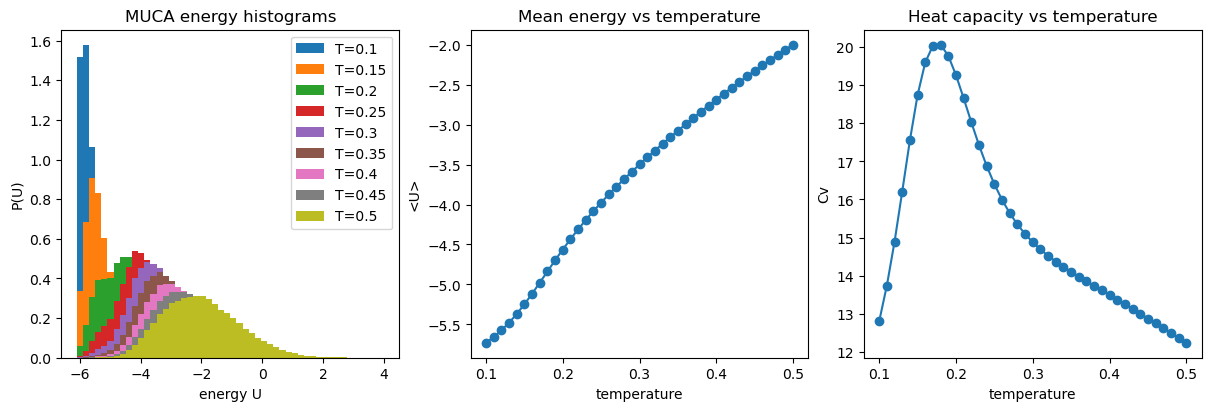

In [39]:
# Energy at some particular temperature assuming DOS is perfect

# Load DOS I made earlier - comment out to use the one computed above
#filename = 'data/dos_f4.8828125e-06.txt'
#wl_logdos = np.loadtxt(filename)

#temperatures = np.arange(0.1, 0.55, 0.05)
temperatures = np.arange(0.1, 0.51, 0.01)

# Setup plots
%matplotlib inline
fig.clf()
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1.set_xlabel('energy U')
ax1.set_ylabel('P(U)')
ax1.set_title("MUCA energy histograms")

ax2.set_xlabel('temperature')
ax2.set_ylabel('<U>')
ax2.set_title('Mean energy vs temperature')  

ax3.set_xlabel('temperature')
ax3.set_ylabel('Cv')
ax3.set_title('Heat capacity vs temperature') 

# Initialise arrays 
mean_energies   = np.zeros(len(temperatures))
mean_errors     = np.zeros(len(temperatures))
heat_caps       = np.zeros(len(temperatures))

# Loop over temperatures of interest
for itemp, new_temp in enumerate(temperatures):

    beta = 1.0/new_temp
    prob = np.zeros(len(bin_edges)-1)

    # Energy histogram is just g(U) x exp(-beta U)
    for ibin, edge in enumerate(bin_edges[:-1]):
        bin_energy = edge + 0.5*bin_width
        prob[ibin] = m.exp(wl_logdos[ibin]-beta*bin_energy)

    # Normalise
    prob = prob/np.sum(prob*bin_width)

    # Only plot every 5th histogram to avoid crowding the axes
    if itemp%5 == 0:
        strlabel = "T={:1.2}".format(new_temp)
        ax1.bar(bin_edges[:-1], prob, width=bin_width, align='edge', label=strlabel)
    
    # Mean energy
    mean_energy = np.dot(bin_edges[:-1]+0.5*bin_width, prob)/np.sum(prob)
    mean_energies[itemp] = mean_energy

    # Compute heat capacity using the histogram
    msq_dev = np.zeros(len(bin_edges)-1)
    for ibin, edge in enumerate(bin_edges[:-1]):
        bin_energy = edge + 0.5*bin_width
        msq_dev[ibin] = (bin_energy - mean_energies[itemp])**2
        
    heat_caps[itemp] = np.dot(msq_dev, prob)*bin_width/(new_temp**2) + (Ndims/2)*(Nbeads-1)


# Complete plots using data computed above
ax1.legend()
ax2.errorbar(temperatures, mean_energies,yerr=mean_errors, fmt='-o')
ax3.plot(temperatures, heat_caps, '-o', label='samples')
plt.show()

# Store heat_caps for comparison to alternative compuation below
hist_heat_caps = heat_caps;

## Sample reweighting

This is all fine provided the only quanities I want to know at any temperature can be computed directly from the energy histogram. Any other quantities need to sampled during a WL run with *fixed* $g(u)$ along with the corresponding microstate energy $U$ so that we can give them an appropriate weight at the new temperature.

In the following we'll record samples of both energy $U$ and end-to-end distance $L$ as usual.

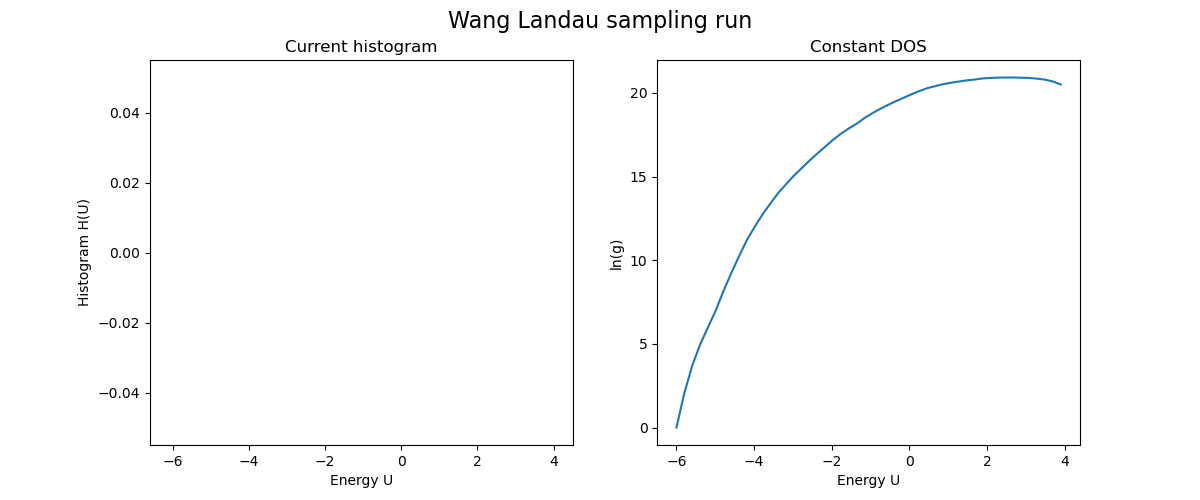

In [38]:
# Initialise wl_simulation with a fixed g(U)
Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Initialise histogram 
wl_hist   = np.zeros(len(bin_edges)-1)

# Load DOS I made earlier - comment out to use those generated above
#filename = 'data/dos_f4.8828125e-06.txt'
#wl_logdos = np.loadtxt(filename)

# No further modification to density of states
wl_f = 0.0

# Setup some plots
%matplotlib widget

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
label_wl_figure(fig, ax1, ax2, wl_f)
ax1.bar(bin_edges[:-1], wl_hist, width=bin_width, align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
fig.suptitle('Wang Landau sampling run', fontsize=16)
ax2.set_title('Constant DOS')
plt.show()

In [44]:
from ipywidgets import IntProgress
from IPython.display import display
import time

Nframes = 5000 # number of frames to run with fixed weights

# I like a progress bar
f = IntProgress(min=0, max=Nframes)
display(f) # display the bar

# Initialise sampled quantities
samples = []

for iframe in range(Nframes):
    

    chain, new_samples, wl_hist, wl_logdos, ratio = run_wl_sweeps(chain, bin_edges, wl_hist, wl_logdos, wl_f, max_disp=0.1)
    samples = samples + new_samples
    f.value +=1  # Increment progress bar

    # Update plots
    ax1.cla(), ax2.cla()
    ax1.bar(bin_edges[:-1], wl_hist,   width=bin_width,align='edge')
    ax2.plot(bin_edges[:-1]+0.5*bin_width, wl_logdos)
    label_wl_figure(fig, ax1, ax2, wl_f)
    fig.suptitle('Wang Landau sampling run', fontsize=16)
    ax1.set_title('Current histogram')
    ax2.set_title('Constant DOS')
    plt.draw()
    
    fig.canvas.draw()
    fig.canvas.flush_events()

    # Save histogram
    #filename = 'data/histogram_f4.8828125e-06.txt'
    #np.savetxt(filename, wl_hist)

    # Save samples
    #filename = 'data/samples_f4.8828125e-06.dat'
    #FILE = open(filename,"w")
    #samples.tofile(FILE)
    #FILE.close()


IntProgress(value=0, max=5000)

<Figure size 640x480 with 0 Axes>

We can use the samples of end-to-end distance obtained in this simulation to compute averages at any temperature by giving the $i$th sample a weight of;

$$ w_i = g(U_i) \exp{[-\beta U_i]} $$

if we treat our estimate of $g(U)$ as perfect, or alternatively;

$$ w_i = g(U_i) \exp{[-\beta U_i]}/\tilde{P}(U_i) $$

where $\tilde{P}(U_i)$ is the multicanonical probability distribution we obtained with the fixed density of states estimate. In a perfect world this would be exactly flat and so wouldn't have any impact on the relative sample weights.

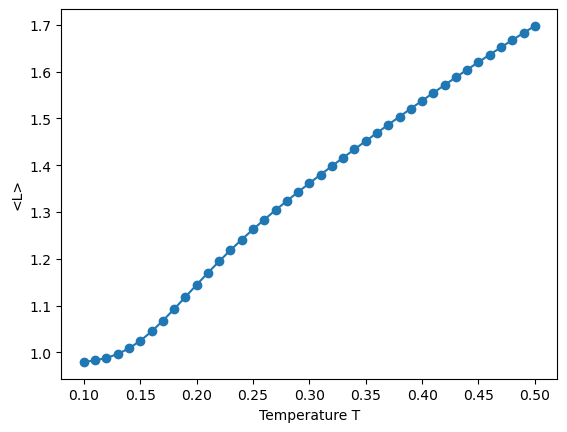

In [45]:
# Do something with the samples
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

# End to end distance as a function of temperature
temperatures = np.arange(0.1, 0.51, 0.01)

# Array of average end-to-end distances
mean_end2end = np.zeros(len(temperatures))

# Loop over temperatures of interest
for itemp, new_temp in enumerate(temperatures):

    beta = 1.0/new_temp
    
    # Array of weights for every sample
    weights = np.zeros(len(energy_samples))
    
    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        bin_energy = edge + 0.5*bin_width
        weights[isamp] = m.exp(wl_logdos[ibin]-beta*bin_energy)/wl_hist[ibin]

    # Mean end to end distance is dot product of samples and weights
    mean_end2end[itemp] = np.dot(end2end_samples, weights)/np.sum(weights)


%matplotlib inline
fig.clf()
fig, ax = plt.subplots()
plt.plot(temperatures, mean_end2end,'o-')
ax.set_xlabel('Temperature T')
ax.set_ylabel('<L>')
plt.show()

For completeness, we can also weight each sample of energy individually to compute (e.g.) heat capacity without using the discretised energies at the centre of the histogram bin.

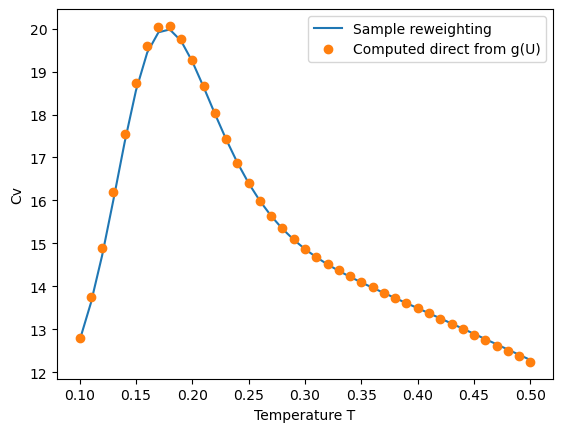

In [48]:
# Heat capacity as a function of temperature
temperatures = np.arange(0.1,0.51,0.01)

heat_cap = np.zeros(len(temperatures))

for itemp, new_temp in enumerate(temperatures):
    
    beta = 1.0/new_temp
    prob = np.zeros(len(bin_edges)-1)

    # We use the bins only to determine the density of states estimate at the current sample energy
    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        bin_energy = edge + 0.5*bin_width
        weights[isamp] = m.exp(wl_logdos[ibin]-beta*bin_energy)/wl_hist[ibin]    

    mean_energy = np.dot(energy_samples, weights)/np.sum(weights)
    delta_energy_sq = [(energy - mean_energy)**2 for energy in energy_samples]
    mean_deltaE_sq = np.dot(delta_energy_sq, weights)/np.sum(weights)
    
    heat_cap[itemp] = mean_deltaE_sq/(new_temp**2) + (Ndims/2)*(Nbeads-1)

# Plot and compare to that obtained by reweighting the histogram
fig, ax = plt.subplots()
plt.plot(temperatures, heat_cap,'-', label='Sample reweighting')
plt.plot(temperatures, hist_heat_caps,'o', label='Computed direct from g(U)')
ax.set_xlabel('Temperature T')
ax.set_ylabel('Cv')
ax.legend()
plt.show()